In [1]:
import pathlib
# from tqdm import tqdm
# from tqdm.notebook import trange, tqdm
from tqdm.autonotebook import tqdm
import random
import collections
import math 
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from time import time
import platform
import os
from skimage.util.shape import view_as_windows
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', '{:,.4f}'.format)

_platform = platform.platform()
print('platform:', _platform, platform.node())
if 'linux' in _platform: # linux
    video_path = '/home/cclee/image_data/'
    out_path = '/home/cclee/tmp/rat/'
    train_path = '/home/cclee/tmp/rat/training_grooming/'
elif 'Darwin' in _platform: # MAC OS X
    mp4_path = '/Users/cclee/image_data/ratmp4/'
    groom_path = '/Users/cclee/rat_data/training_grooming/'
    data_path = '/Users/cclee/rat_data/' 
    out_path = '/Users/cclee/rat_data/new_out/' 
    new_groom_path = '/Users/cclee/rat_data/new_grooming/'
    new_groom_path_old = '/Users/cclee/rat_data/new_grooming_old/'
    short_path = '/Users/cclee/rat_data/short_clip/'
elif 'Windows' in _platform: # Windows
    if platform.node()=='Mozart':
        mp4_path = 'e:/image_data/ratmp4'
        groom_path = 'e:/rat_data/training_grooming'
        data_path = 'e:/rat_data/'
        out_path = 'e:/rat_data/new_out'
        new_groom_path = 'e:/rat_data/new_grooming_0311/'
        new_groom_path_old = 'e:/rat_data/new_grooming_old/'
        short_path = 'e:/rat_data/short_clip/'
    else:
        mp4_path = 'd:/image_data/ratmp4'
        groom_path = 'd:/rat_data/training_grooming'
        data_path = 'd:/rat_data/'  
        out_path = 'd:/rat_data/new_out'
        new_groom_path = 'd:/rat_data/new_grooming/'
        new_groom_path_old = 'd:/rat_data/new_grooming_old/'
        short_path = 'd:/rat_data/short_clip/'
    
dpath = pathlib.Path(data_path)
mp4path = pathlib.Path(mp4_path)
outpath = pathlib.Path(out_path)
groompath = pathlib.Path(groom_path)
newgroompath = pathlib.Path(new_groom_path)
shortpath = pathlib.Path(short_path)
newgroom_oldpath = pathlib.Path(new_groom_path_old)
groom_revised_path = dpath.joinpath('new_grooming_rev1')

read_cols = (0, 6, 10, 11, 12)
exp_lst = [921111,921216,930203,930217, 930302, 930309]

if not outpath.exists():
    outpath.mkdir()    
    
if not newgroompath.exists():
    newgroompath.mkdir() 
    
if not shortpath.exists():
    shortpath.mkdir()     

C:\Users\cclee\AppData\Local\Temp/ipykernel_36796/1241500581.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


platform: Windows-10-10.0.19041-SP0 Mozart


# Rat Class
## determine label sequence based on thresholds

In [4]:

jump_rows = 5
th_min_duration = 10
thMin = 0.009
thMax = 0.08
left_right = 'L'
mid_line = 180  
width = None
height = None
fps = 20
fps_out = 10   
frame_loc = 0    
    
dot_a = np.array([2**i for i in range(11,-1, -1)])
print(dot_a)

dot_b = np.array([2**i for i in range(22,-1, -1)])
print(dot_b)

def read_data(filename, cols):   
    df_diff = pd.read_csv(filename, index_col=0, usecols=cols)
    df_diff = df_diff.fillna(method='ffill')
    df_diff = df_diff.fillna(method='bfill')

    return df_diff

def write_video(cap, start, end, fps_out, lr, vdate):
    global frame_loc
    
    sec = start /fps
    minutes = sec // 60    
    hh = int(minutes // 60)
    mm = int(minutes % 60)
    ss = sec - hh*60*60 - mm*60

    dur = (end-start) / fps
#   print('start {}, end {}'.format(start, end))
    if lr=='L':
        w = mid_line
    else:
        w = width - mid_line

#     outName = '{}/{:s}_{:s}{:05d}_{:02d}{:02d}{:05.02f}-{:.2f}.mp4'.format(
#             str(out_dir), vdate, lr, start, hh, mm, ss, dur) 
    clip_len = end-start+1
    outName = '{}/{:s}_{:s}{:05d}_{:05d}_{}.mp4'.format(str(out_dir), vdate, lr, start, end, clip_len)
    vidw = cv2.VideoWriter(outName, cv2.VideoWriter_fourcc(*'avc1'),  ####XVID'), 
                           fps_out, (w, height), True)  # Make a video

    if vidw.isOpened()==True:
        while frame_loc < start:
            bVideoRead, frame = cap.read()
            frame_loc += 1

        while frame_loc <= end:
            bVideoRead, frame = cap.read()
            frame_loc += 1
            if bVideoRead:
                if lr=='L':
                    vidw.write(frame[:, 0:mid_line])
                else:
                    vidw.write(frame[:, mid_line: width])
            else:
                break
        vidw.release()    
    else:
        print('output video error: ' , outName)
            
            
def write_features(df_diff, start, end, fps_out, lr, vdate):   
    sec = start /fps
    minutes = sec // 60    
    hh = int(minutes // 60)
    mm = int(minutes % 60)
    ss = sec - hh*60*60 - mm*60

#        idx = pd.Index(self.data[start:end+1, 0], dtype='int64')
    idx = pd.Index(np.arange(start, end+1))
    ser_nonzero_p1 = df_diff.loc[start:end, 'nonzero_p1']
    ser_nonzero_p5 = df_diff.loc[start:end, 'nonzero_p5']
    freqStr = '{0:d}L'.format(int(1000 /fps_out))
    time_clip = pd.date_range(0, periods=end-start+1, freq=freqStr)

    start_time = '2000-01-01 {}:{}:{}'.format(hh, mm, ss)
    freqStr = '{0:d}L'.format(int(1000 /fps))
#    print(start_time, 'start{}, sec{}, ss{}, mm{}]'.format(start, sec, ss, mm) ) 
    time_video = pd.date_range(start_time, periods=end-start+1, freq=freqStr)

    ser_time_clip = pd.Series(time_clip, idx)
    ser_time_video = pd.Series(time_video, idx)
    df = pd.DataFrame({'nonzero_p1':ser_nonzero_p1, 
                       'nonzero_p5':ser_nonzero_p5,
                       'tm_clip':ser_time_clip,
                       'tm_video':ser_time_video})


    clip_len = end-start+1
    outcsvName = '{}/{:s}_{:s}{:05d}_{:05d}_{}.csv'.format(str(out_dir), vdate, lr, start, end, clip_len) 
#         print('outcsvName:', outcsvName)
    df.to_csv(outcsvName, date_format='%H:%M:%S.%f')
     
        
def gen_clip(df_diff, filename):
    global fps
    global fps_out
    global frame_loc
    global width 
    global height 
    
    frame_loc = 0
    fname_name = filename.stem
    name_lst = fname_name.split('_')
    left_right = name_lst[2]
    vdate = name_lst[3]
#     print('name_lst ',fname_name, name_lst, left_right, vdate)
    
#        data_p1 = self.data[:, 1]
    data_p5 = df_diff.loc[:, 'nonzero_p5']
    total_frames = len(data_p5)
    # each sample represents 5 frames (5 sec)
    moving_win = view_as_windows(data_p5.values, (10,), 5)
    win_mean = np.mean(moving_win, axis=1)
    label = (win_mean > thMin) & (win_mean < thMax)
    label[:jump_rows] = False
    label =1*label
#         print('win_mean.shape %d' % win_mean.shape)
#         print('nonzero of label %d' % np.count_nonzero(label))        
    label_median = signal.medfilt(label,3)
    label_median1 = signal.medfilt(label_median,3)
 
    # remove/merge TTT in sleep --------------------------------------------
#     moving_win = view_as_windows(label_median1, (23,), 1)
#     dot = np.dot(moving_win, dot_b)
#     dot3T = np.append(dot, [label_median1[-22:]])
    
#     final_label3T = label_median1.copy()
#     for i in range(dot3T.shape[0]):
#         if dot3T[i]==7168:
#             final_label3T[i:i+23] = 0
            
    # remove/merge  TT in sleep ------------------------------------------
    moving_win = view_as_windows(label_median1, (12,), 1)
    dot = np.dot(moving_win, dot_a)
    dot2T = np.append(dot, [label_median1[-11:]])
    
    final_label2T = label_median1.copy()
    for i in range(dot2T.shape[0]):
        if dot2T[i]==96:
            final_label2T[i:i+12] = 0
   

            
#     print(dot.shape)
#     print(label_median.shape)
    df = pd.DataFrame({'label':label,'label_md':label_median, 'label_md1':label_median1, 
#                        'dot3T':dot3T, 'final_label_3T':final_label3T,
                       'dot2T':dot2T, 'final_label_2T':final_label2T})     
    out_label = out_dir.joinpath('_label_{}.csv'.format(left_right))
    df.to_csv(out_label)

    video_lst = list(mp4path.glob('{}*.mp4'.format(vdate)))
    if len(video_lst) != 1:
        print('video file ERROR')
        print(video_lst)
        return
    
    video_file = str(video_lst[0])
    if left_right=='L':
        print('    video file: ', video_file )

    cap = cv2.VideoCapture(video_file)
    bOpenVideo = cap.isOpened()
    if bOpenVideo == False:
        print('Open Video failed')
        return

    video_fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

#     fps_out = 10 #Rat.fps //2
    freqStr = '{0:d}L'.format(int(1000 /fps_out))

    if left_right=='L':
        print('    fps = %d, video fps %d, w %d, h %d, total_frames %d, freq_out %s' % 
              (fps, video_fps, width, height, total_frames, freqStr))

    bVideoWR = False
    extract_clips = 0

    for i in range(5, final_label2T.size):
        frameCounter = i * 5

        if final_label2T[i] == True:
            #print(win_mean[i])
            if bVideoWR == False:
                start_frame = frameCounter
                end_frame = frameCounter
                bVideoWR = True
            else:
                if frameCounter < total_frames:
                    end_frame = frameCounter
                else:
                    end_frame = total_frames 

        else:
            if bVideoWR == True:
                bVideoWR = False
                if end_frame - start_frame+5 >= th_min_duration:
                    write_features(df_diff, start_frame, end_frame+4, fps_out, left_right, vdate)
                    write_video(cap, start_frame, end_frame+4, fps_out, left_right, vdate)
                    extract_clips += 1

        # pbar.update(i)

    # pbar.finish()      
#         print('extract_clips: ', extract_clips)
        

[2048 1024  512  256  128   64   32   16    8    4    2    1]
[4194304 2097152 1048576  524288  262144  131072   65536   32768   16384
    8192    4096    2048    1024     512     256     128      64      32
      16       8       4       2       1]


# step2: generate video clips and clip csv files
## step1要先產生diff檔,  python gen_diff_data_20200617.py
## 再根據 diff檔 (e.g., _diff_L_930221.csv)  去切 
### 做好上面步驟後，需要人工挑選, 
### 再把grooming 片段的 csv 放到 E:\tmp\rat\training_grooming 裡面 or new_grooming
### 之後才能進行step3 label_training_data, 才會輸出_label_921111.csv 這種檔

In [6]:
print('search diff file from ',str(dpath))
print('min duration %d, diff thresh [%.4f %.4f]' % (th_min_duration, thMin, thMax))

rat_lst = ['921111', '930217', '930302', '930316', '921216', '930203']   
# ratmp4 =['930217', '930219','930316', '930317', '930318'] # ['930317', '930318', '930323', '930324', '930325']

rat_lst_full = []
for rat in rat_lst:
    r = int(rat)
    for i in range(3):
        rr = r + i
        rat_lst_full.append(str(rr))
        
print(rat_lst_full)


ddir = [x for x in dpath.iterdir() if x.is_dir() and x.name.split('-')[0] in rat_lst_full]
# ddir = [x for x in dpath.iterdir() if x.is_dir() and x.name[0]=='9']
ddir = sorted(ddir)

pbar = tqdm(total=len(ddir))
for dd in ddir:  
    fdate = dd.name.split('-')[0]  
    print('{:20s} {}'.format(dd.name, fdate))
    diff_r = '_diff_R_'+fdate + '.csv'
    diff_l = '_diff_L_'+fdate + '.csv'
    fpath = dd.joinpath(diff_r)
    if not fpath.exists():
        print('no diff data:', fpath)
        continue
#     print(diff_r, diff_l)
    out_dir = outpath.joinpath(dd.name)
    print('out_dir ', out_dir)
    
    if out_dir.exists():
        shutil.rmtree(out_dir)
#         pass
    if not out_dir.exists():
        out_dir.mkdir()         
    
    filename = dd.joinpath(diff_l)
    df_diff_l = read_data(filename, cols=read_cols)
    gen_clip(df_diff_l, filename)
    shutil.copyfile(filename, out_dir.joinpath(diff_l))
    
    filename = dd.joinpath(diff_r)
    df_diff_r = read_data(filename, cols=read_cols)        
    gen_clip(df_diff_r, filename)
    shutil.copyfile(filename, out_dir.joinpath(diff_r))

    pbar.update(1)
#     break

search diff file from  e:\rat_data
min duration 10, diff thresh [0.0090 0.0800]
['921111', '921112', '921113', '930217', '930218', '930219', '930302', '930303', '930304', '930316', '930317', '930318', '921216', '921217', '921218', '930203', '930204', '930205']


921111-base-1d       921111
out_dir  e:\rat_data\new_out\921111-base-1d
    video file:  e:\image_data\ratmp4\921111-base-1d.mp4
    fps = 20, video fps 20, w 352, h 240, total_frames 79985, freq_out 100L
921112-base-2d       921112
out_dir  e:\rat_data\new_out\921112-base-2d
    video file:  e:\image_data\ratmp4\921112-base-2d.mp4
    fps = 20, video fps 20, w 352, h 240, total_frames 85643, freq_out 100L
921113-B-car-3-1d    921113
out_dir  e:\rat_data\new_out\921113-B-car-3-1d
    video file:  e:\image_data\ratmp4\921113-B-car-3-1d.mp4
    fps = 20, video fps 20, w 352, h 240, total_frames 80178, freq_out 100L
921216-base-1d       921216
out_dir  e:\rat_data\new_out\921216-base-1d
    video file:  e:\image_data\ratmp4\921216-base-1d.mp4
    fps = 20, video fps 20, w 352, h 240, total_frames 81073, freq_out 100L
921217-base-2d       921217
out_dir  e:\rat_data\new_out\921217-base-2d
    video file:  e:\image_data\ratmp4\921217-base-2d.mp4
    fps = 20, video fps 20, w 352, h 240, tot

# step3 label_training_data
##  輸出_label_921111.csv 這種檔

In [4]:
sigma = 1.5
print('gaussian_filter1d, sigma=',sigma)
ratpath = outpath # new_out
# dpath = pathlib.Path(out_path)
# trpath = pathlib.Path(train_path)
train_list = sorted(newgroompath.glob('9*.csv'))
date_lst = []
lr_lst = []
start_lst = []
end_lst = []
for f in train_list:
    fname = f.name
    ftoken = fname.split('_')
    fdate = ftoken[0]
    fend = int(ftoken[2])
    fLR=  ftoken[1][0]
    fstart = int(ftoken[1][1:])
#        print(fdate, fLR, fstart, fend)
    date_lst.append(fdate)
    lr_lst.append(fLR)
    start_lst.append(fstart)
    end_lst.append(fend)

#     print(fdate, fLR, fstart, fend)
#     break

date_uq = list(set(date_lst))

sr_date = pd.Series(date_lst)
sr_lr = pd.Series(lr_lst)
sr_start = pd.Series(start_lst)
sr_end = pd.Series(end_lst)
df_train = pd.DataFrame({'date':sr_date, 'lr':sr_lr, 'start':sr_start, 'end':sr_end},
                  columns=['date','lr','start','end'])

fname = '_grooming_loc.csv'
fname1 = newgroompath.joinpath(fname)
print(fname1)
df_train.to_csv(str(fname1))


ddir = [x for x in ratpath.iterdir() if x.is_dir()]
for dd in ddir:      
    print('Check folder: ', dd)
    for ddate in date_uq:
        if ddate in str(dd):
            print('\tprocess ', ddate)
            diffrr = '_diff_R_' + ddate + '.csv'
            diffll = '_diff_L_' + ddate + '.csv'
            rrname = dd.joinpath(diffrr)
            llname = dd.joinpath(diffll)
            df = pd.read_csv(rrname, delimiter=',',index_col=0)
            df = df.fillna(method='ffill')
            df = df.fillna(method='bfill')

            df['label']=0
            mask = (df_train['date']==ddate) & (df_train['lr']=='R')
            df_sel = df_train[mask]
            for row in df_sel.itertuples():
                df.loc[row.start:row.end,'label'] = 1

            arr = df.loc[:,'diffSum_p1':'cy']
            smooth_arr = ndimage.gaussian_filter1d(arr, sigma = sigma, axis =0 )
            header = list(df.columns)[:-2]
            header_smoo = [i + '_smoo' for i in header ]
            df_smoo = pd.DataFrame(smooth_arr, columns = header_smoo)
            df_m = pd.concat([df, df_smoo], axis=1)
            fname1 = newgroompath.joinpath('_label_' + ddate + '_R.csv')
            df_m.to_csv(str(fname1))

            df = pd.read_csv(llname, delimiter=',',index_col=0)
            df = df.fillna(method='ffill')
            df = df.fillna(method='bfill')

            df['label']=0
            mask = (df_train['date']==ddate) & (df_train['lr']=='L')
            df_sel = df_train[mask]
            for row in df_sel.itertuples():
                df.loc[row.start:row.end,'label'] = 1

            arr = df.loc[:,'diffSum_p1':'cy']
            smooth_arr = ndimage.gaussian_filter1d(arr, sigma = 1.5, axis =0 )
            header = list(df.columns)[:-2]
            header_smoo = [i + '_smoo' for i in header ]
            df_smoo = pd.DataFrame(smooth_arr, columns = header_smoo)
            df_m = pd.concat([df, df_smoo], axis=1)

            fname1 = newgroompath.joinpath('_label_' + ddate + '_L.csv')
            df_m.to_csv(str(fname1))

gaussian_filter1d, sigma= 1.5
e:\rat_data\new_grooming\_grooming_loc.csv
Check folder:  e:\rat_data\new_out\921111-base-1d
	process  921111
Check folder:  e:\rat_data\new_out\921112-base-2d
	process  921112
Check folder:  e:\rat_data\new_out\921113-B-car-3-1d
	process  921113
Check folder:  e:\rat_data\new_out\921114-B-car-3-2d
Check folder:  e:\rat_data\new_out\921115-B-car-3-3d
Check folder:  e:\rat_data\new_out\921116-B-car-3-4d
Check folder:  e:\rat_data\new_out\921119-B-car-3-7d
Check folder:  e:\rat_data\new_out\921120-B-car-3-8d
Check folder:  e:\rat_data\new_out\921121-B-car-3-9d
Check folder:  e:\rat_data\new_out\921122-B-car-3-10d
Check folder:  e:\rat_data\new_out\921123-B-car-3-11d
Check folder:  e:\rat_data\new_out\921128-B-car-3-16d
Check folder:  e:\rat_data\new_out\921129-B-car-3-17d
Check folder:  e:\rat_data\new_out\921130-B-car-3-18d
Check folder:  e:\rat_data\new_out\921201-B-car-3-19d
Check folder:  e:\rat_data\new_out\921202-B-car-3-20d
Check folder:  e:\rat_data\

# Update old /training_grooming/*.csv
## new: e:/rat_data/new_out
## old: e:/rat_data/training_grooming
##  (copy csv and mp4 to new_groom_old path)

In [4]:
def modify_grooming_csv(groom_lst, newcsv_lst):
    copy_num = 0
    for groom in groom_lst:
        lst = groom.stem.split('_')
        groo_start = int(lst[1][1:])
        groo_end = int(lst[2])
#         print('groom ', groo_start, groo_end)
        bcopy = False
        for newcsv in newcsv_lst:
            lst = newcsv.stem.split('_')
            newcsv_start = int(lst[1][1:])
            newcsv_end = int(lst[2])
#             print('newcsv ', newcsv_start, newcsv_end)   
            
            if newcsv_start <= groo_start < newcsv_end:
                shutil.copyfile(newcsv, newgroom_oldpath.joinpath(newcsv.name) )
                
                # copy mp4 to newgroompath
                video_lst = list(out_dir.glob('{}_{}*.mp4'.format(lst[0], lst[1])))
                if len(video_lst) != 1:
                    print('video file ERROR')
                    print(video_lst)
                    break
                video_file = video_lst[0]
                shutil.copyfile(video_file, newgroom_oldpath.joinpath(video_file.name) )
            
            
                copy_num +=1
                bcopy = True
        if not bcopy:
            print('   ------------ cannot find ', groom.stem)
#         break
    print('    num of groom_lst {}, copy {}'.format(len(groom_lst), copy_num))
    return copy_num

In [7]:
exp_lst = [930316, 930323, 930330]
rat_lst = ['930316','930317', '930318', '930323', '930324', '930325', '930330']
ddir = [x for x in outpath.iterdir() if x.is_dir() and x.name.split('-')[0] in rat_lst]
print('old csv: ', groompath)
print('copy to ', new_groom_path_old)
ddir = sorted(ddir)
pbar = tqdm(total=len(ddir))
total_copy = 0
for dd in ddir:  
    pbar.update(1)
    
    fdate = int(dd.name.split('-')[0])
    print('{:20s} {}'.format(dd.name, fdate))

    skip = True
    for exp_date in exp_lst:
        if fdate in range(exp_date, exp_date+3):
            skip = False
            break            
    if skip:
        print('    skip this study {}, not in 3 days of {}'.format(fdate, exp_lst))
        continue
        
        
    # left side
    ffilter = '{}_L*.csv'.format(fdate)
    groom_lst = sorted(groompath.glob(ffilter))
    
    out_dir = outpath.joinpath(dd.name)
    print('    compare with new csv: ', out_dir)
    newcsv_lst = sorted(out_dir.glob(ffilter))
    copy_num = modify_grooming_csv(groom_lst, newcsv_lst)
    total_copy += copy_num
    
    # right side
    ffilter = '{}_R*.csv'.format(fdate)
    groom_lst = sorted(groompath.glob(ffilter))
    out_dir = outpath.joinpath(dd.name)
    newcsv_lst = sorted(out_dir.glob(ffilter))
    copy_num = modify_grooming_csv(groom_lst, newcsv_lst)
    total_copy += copy_num

print('total_copy ', total_copy)

old csv:  e:\rat_data\training_grooming
copy to  e:/rat_data/new_grooming_old/


930316-base-1d       930316
new csv:  e:\rat_data\new_out\930316-base-1d
    num of groom_lst 36, copy 36
    num of groom_lst 32, copy 32
930317-base-2d       930317
new csv:  e:\rat_data\new_out\930317-base-2d
    num of groom_lst 39, copy 39
    num of groom_lst 42, copy 42
930318-B-for-1d      930318
new csv:  e:\rat_data\new_out\930318-B-for-1d
    num of groom_lst 48, copy 48
    num of groom_lst 31, copy 31
930323-base-1d       930323
new csv:  e:\rat_data\new_out\930323-base-1d
    num of groom_lst 39, copy 39
    num of groom_lst 36, copy 36
930324-base-2d       930324
new csv:  e:\rat_data\new_out\930324-base-2d
    num of groom_lst 51, copy 51
    num of groom_lst 36, copy 36
930325-B-for-5-1d    930325
new csv:  e:\rat_data\new_out\930325-B-for-5-1d
    num of groom_lst 39, copy 39
    num of groom_lst 32, copy 32
930330-base-1d       930330
new csv:  e:\rat_data\new_out\930330-base-1d
    num of groom_lst 69, copy 69
    num of groom_lst 58, copy 58
total_copy  588


# find short clips, copy to /short_clip
## copy to e:/rat_data/short_clip/

In [8]:
exp_lst = [930316, 930323, 930330]

ddir = [x for x in outpath.iterdir() if x.is_dir() and x.name[0]=='9']
ddir = sorted(ddir)
print(str(outpath))
pbar = tqdm(total=len(ddir))
total_count = 0


for dd in ddir:  
    pbar.update(1)
    fdate = int(dd.name.split('-')[0])
    print('{:20s} {}'.format(dd.name, fdate))    
    skip = True
    for exp_date in exp_lst:
        if fdate in range(exp_date, exp_date+3):
            skip = False
            break            
    if skip:
        print('    skip this study {}, not in 3 days of {}'.format(fdate, exp_lst))
        continue
        
    ffilter = '{}_*.csv'.format(fdate)
    out_dir = outpath.joinpath(dd.name)
    newcsv_lst = sorted(out_dir.glob(ffilter))
    count = 0
    
    short_dir = shortpath.joinpath(dd.name)
    if not short_dir.exists():
        short_dir.mkdir()  
    
    for newcsv in newcsv_lst:
        lst = newcsv.stem.rsplit('_', 1)        
        frame = int(lst[1]) - int(lst[0][-5:]) +1
        frame /= 5
#         print(lst, frame)
        if frame <= 9: ##  45 frames
            # if the csv/mp4 in new_grooming, skip
            csv_lst = list(newgroom_oldpath.glob('{}*.csv'.format(lst[0])))
            if len(csv_lst) >= 1:
                print('    already exists, skip -- ', newcsv.stem)
                continue
            
            shutil.copyfile(newcsv, short_dir.joinpath(newcsv.name) )
            
            video_lst = list(out_dir.glob('{}*.mp4'.format(lst[0])))
            if len(video_lst) != 1:
                print('video file ERROR')
                print(video_lst)
                break

            video_file = video_lst[0]
            shutil.copyfile(video_file, short_dir.joinpath(video_file.name) )
    
            count +=1
    print('    # of short ', count)
    total_count += count
 
#     break
    
    
print('total_count ', total_count)    

e:\rat_data\new_out


921111-base-1d       921111
    skip this study 921111, not in 3 days of [930316, 930323, 930330]
921112-base-2d       921112
    skip this study 921112, not in 3 days of [930316, 930323, 930330]
921113-B-car-3-1d    921113
    skip this study 921113, not in 3 days of [930316, 930323, 930330]
921114-B-car-3-2d    921114
    skip this study 921114, not in 3 days of [930316, 930323, 930330]
921115-B-car-3-3d    921115
    skip this study 921115, not in 3 days of [930316, 930323, 930330]
921116-B-car-3-4d    921116
    skip this study 921116, not in 3 days of [930316, 930323, 930330]
921119-B-car-3-7d    921119
    skip this study 921119, not in 3 days of [930316, 930323, 930330]
921120-B-car-3-8d    921120
    skip this study 921120, not in 3 days of [930316, 930323, 930330]
921121-B-car-3-9d    921121
    skip this study 921121, not in 3 days of [930316, 930323, 930330]
921122-B-car-3-10d   921122
    skip this study 921122, not in 3 days of [930316, 930323, 930330]
921123-B-car-3-11d  

# statistics of short clips, <=45 sec

e:\rat_data\short_clip
921111-base-1d       921111   count  746
921112-base-2d       921112   count  842
921113-B-car-3-1d    921113   count  814
921216-base-1d       921216   count  840
921217-base-2d       921217   count  779
921218-B-car-1-1d    921218   count  840
930203-base-1d       930203   count  839
930204-base-2d       930204   count  867
930205-B-car-1-1d    930205   count  880
930217-base-1d       930217   count  768
930218-base-2d       930218   count  833
930219-B-car-3-1d    930219   count  973
930302-base-1d       930302   count  919
930303-base-2d       930303   count  872
930304-B-for-5-1d    930304   count  797
930309-base-1d       930309   count  823
930310-base-2d       930310   count  833
930311-B-for-5-1d    930311   count  877
total count  15142


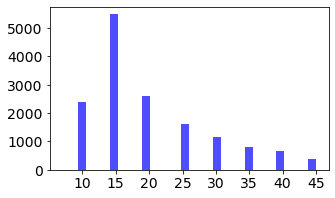

In [2]:
# shortpath = pathlib.Path('E:\\rat_data\\new_grooming_short')
ddir = [x for x in shortpath.iterdir() if x.is_dir() and x.name[0]=='9']
ddir = sorted(ddir)
print(str(shortpath))
total_count = 0

len_lst = []
for dd in ddir:  

    fdate = int(dd.name.split('-')[0])
    print('{:20s} {}'.format(dd.name, fdate), end = '   ')    
        
    ffilter = '{}_*.csv'.format(fdate)
#     short_dir = shortpath.joinpath(dd.name)
    newcsv_lst = sorted(dd.glob(ffilter))
    count = 0
     
    for newcsv in newcsv_lst:
        lst = newcsv.stem.split('_')
        start = int(lst[1][1:])
        end = int(lst[2])
        clip_len = end-start+1
        len_lst.append(clip_len)
        
    print('count ', len(newcsv_lst))
    
print('total count ', len(len_lst))    

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
hist,_,_ = ax.hist(len_lst, bins=32, density =False, fc='#2222FF', alpha=0.8)    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)  

# statistics of short grooming, <=45 sec

E:\rat_data\new_grooming_short
short_grooming max len  45
short_grooming total count  1752
len45:  55


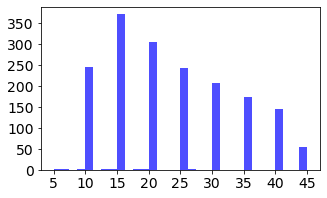

In [4]:
short_grooming_path = pathlib.Path('E:\\rat_data\\new_grooming_short')
csv_lst = sorted(short_grooming_path.glob('9*.csv'))

print(str(short_grooming_path))
total_count = 0
len45 =0
short_grooming_len_lst = []
len_dict = collections.defaultdict(int)

for newcsv in csv_lst:
    lst = newcsv.stem.split('_')
    start = int(lst[1][1:])
    end = int(lst[2])
    clip_len = int(lst[3])
#     clip_len = end-start+1
    short_grooming_len_lst.append(clip_len)
    len_dict[clip_len] +=1
    if clip_len > 45:
        print(newcsv)
    if clip_len==45:
        len45 +=1
        
print('short_grooming max len ', max(short_grooming_len_lst))   
print('short_grooming total count ', len(short_grooming_len_lst))    
print('len45: ', len45)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
hist,_,_ = ax.hist(short_grooming_len_lst, bins=32, density =False, fc='#2222FF', alpha=0.8)    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

# statistics of new grooming clips

d:\rat_data\new_grooming
find csv  3194
max len 690, fname 921112_L43345_44034_690
total count  3194 5 690
len45:  180
690
[(5, 1), (7, 1), (9, 1), (10, 244), (11, 1), (13, 1), (14, 3), (15, 370), (18, 2), (19, 1), (20, 304), (25, 242), (27, 1), (30, 206), (35, 173), (40, 146), (45, 180), (50, 95), (55, 83), (60, 71), (65, 78), (70, 76), (75, 66), (80, 47), (85, 50), (90, 52), (95, 37), (100, 46), (105, 41), (110, 47), (115, 38), (120, 26), (125, 24), (130, 29), (135, 19), (140, 15), (145, 18), (150, 20), (155, 22), (160, 17), (165, 18), (170, 13), (175, 21), (180, 13), (185, 8), (190, 9), (195, 8), (200, 11), (205, 9), (210, 10), (215, 1), (220, 7), (225, 8), (230, 7), (235, 9), (240, 8), (245, 6), (250, 4), (255, 3), (260, 8), (265, 7), (270, 6), (275, 5), (280, 7), (285, 5), (290, 5), (295, 5), (300, 3), (305, 7), (310, 2), (315, 3), (320, 4), (325, 2), (330, 1), (335, 1), (345, 1), (350, 3), (355, 1), (360, 1), (365, 4), (375, 3), (380, 2), (385, 2), (390, 2), (395, 6), (405, 2), (

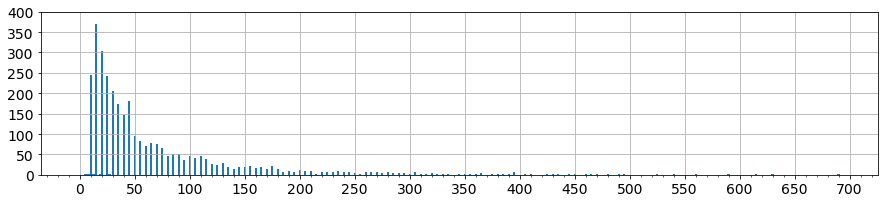

In [7]:
print(str(newgroompath))
newcsv_lst = sorted(newgroompath.glob('9*.csv'))
print('find csv ', len(newcsv_lst))
len_lst = []
name_lst = []
len45 =0

len_dict = collections.defaultdict(int)

for newcsv in newcsv_lst:
    lst = newcsv.stem.split('_')
    start = int(lst[1][1:])
    end = int(lst[2])
    clip_len = end-start+1
    len_lst.append(clip_len)
    name_lst.append(newcsv.stem)
    len_dict[clip_len] +=1
    if clip_len==45:
        len45 +=1
        
print('max len {}, fname {}'.format(max(len_lst), name_lst[np.argmax(len_lst)]))
print('total count ', len(len_lst), min(len_lst), max(len_lst))    
print('len45: ', len45)
    
# fig, ax = plt.subplots(1, 1, figsize=(15, 3))
# hist1,_,_ = ax.hist(len_lst, bins=300, density =False, fc='#2222FF', alpha=0.8)    

# ax.xaxis.set_major_locator(MultipleLocator(50))
# ax.xaxis.set_minor_locator(MultipleLocator(10))

# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14) 
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)  
    
    
# print(hist1[:200])
# print(len(hist1))  
# print(len_dict)
# print(len_dict[45])
print(max(list(len_dict.keys())))
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
max_len = max(list(len_dict.keys()))
y_lst = [0] * (max_len+1)
for k, v in len_dict.items():
    y_lst[k] = v
    
b_lst = [(k,v) for k, v in len_dict.items()]   
b_lst = sorted(b_lst)
print(b_lst)

sumy = 0
for k,v in b_lst:
    sumy += v*k
    if k==45:
        print(k,sumy)
    elif k==100:
        print(k,sumy)
    elif k==150:
        print(k,sumy)
    elif k==200:
        print(k,sumy)
    
ax.bar(range(max_len+1), y_lst, align='center', width = 2);
ax.set_xticks(range(max_len+1)) #, list(len_dict.keys()));
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.set_ylim(0, 400)
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)  

# statistics of old-updated grooming clips

e:\rat_data\new_grooming_old
find csv  1443
max len 690, fname 921112_L43345_44034_690
total count  1443 45 690
len45:  126
[(45, 126), (50, 95), (55, 83), (60, 71), (65, 78), (70, 76), (75, 66), (80, 47), (85, 50), (90, 52), (95, 37), (100, 46), (105, 41), (110, 47), (115, 38), (120, 26), (125, 24), (130, 29), (135, 19), (140, 15), (145, 18), (150, 20), (155, 22), (160, 17), (165, 18), (170, 13), (175, 21), (180, 13), (185, 8), (190, 9), (195, 8), (200, 11), (205, 9), (210, 10), (215, 1), (220, 7), (225, 8), (230, 7), (235, 9), (240, 8), (245, 6), (250, 4), (255, 3), (260, 8), (265, 7), (270, 6), (275, 5), (280, 7), (285, 5), (290, 5), (295, 5), (300, 3), (305, 7), (310, 2), (315, 3), (320, 4), (325, 2), (330, 1), (335, 1), (345, 1), (350, 3), (355, 1), (360, 1), (365, 4), (375, 3), (380, 2), (385, 2), (390, 2), (395, 6), (405, 2), (410, 2), (425, 1), (430, 2), (435, 2), (445, 2), (450, 1), (460, 1), (465, 3), (470, 1), (480, 2), (490, 2), (495, 1), (525, 1), (540, 2), (560, 1), (590,

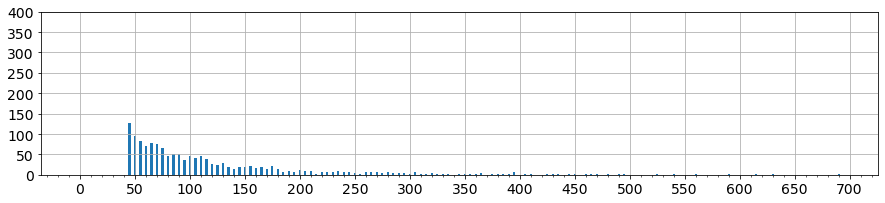

In [13]:
print(str(newgroom_oldpath))
newcsv_lst = sorted(newgroom_oldpath.glob('9*.csv'))
print('find csv ', len(newcsv_lst))
len_lst = []
name_lst = []
len45 =0
len_dict = collections.defaultdict(int)
for newcsv in newcsv_lst:
    lst = newcsv.stem.split('_')
    start = int(lst[1][1:])
    end = int(lst[2])
    clip_len = end-start+1
    len_lst.append(clip_len)
    name_lst.append(newcsv.stem)
    len_dict[clip_len] +=1
    if clip_len==45:
        len45 +=1
        
print('max len {}, fname {}'.format(max(len_lst), name_lst[np.argmax(len_lst)]))
print('total count ', len(len_lst), min(len_lst), max(len_lst))    
print('len45: ', len45)
# fig, ax = plt.subplots(1, 1, figsize=(15, 3))
# hist2,_,_ = ax.hist(len_lst, bins=300, density =False, fc='#2222FF', alpha=0.8)    
# ax.xaxis.set_major_locator(MultipleLocator(50))
# ax.xaxis.set_minor_locator(MultipleLocator(10))
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14) 
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)  

# print(hist2)
# print(len(hist2))

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
max_len = max(list(len_dict.keys()))
y_lst = [0] * (max_len+1)
for k, v in len_dict.items():
    y_lst[k] = v
    
b_lst = [(k,v) for k, v in len_dict.items()]    
print(sorted(b_lst))

ax.bar(range(max_len+1), y_lst, align='center', width = 2);
ax.set_xticks(range(max_len+1), list(len_dict.keys()));
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.set_ylim(0, 400)
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)  

# statistics of old non-updated grooming clips (training_grooming)

e:\rat_data\training_grooming
input a single study name: ("921112_L" or "all" )all
find csv  4238
max len 686, fname 921112_L43345_44005_661
min len 40, fname 930303_L80216_80230_15
total count  1622 40 686
[(15, 1), (16, 190), (21, 149), (22, 1), (26, 127), (28, 1), (29, 1), (31, 101), (36, 105), (37, 1), (41, 97), (42, 2), (43, 1), (46, 71), (49, 1), (51, 78), (56, 66), (61, 64), (66, 44), (71, 46), (76, 45), (81, 38), (86, 39), (91, 24), (92, 1), (96, 22), (101, 18), (106, 24), (111, 15), (116, 17), (121, 16), (126, 22), (131, 14), (136, 16), (141, 10), (146, 11), (151, 12), (156, 10), (161, 7), (166, 8), (168, 1), (171, 6), (176, 7), (181, 8), (186, 5), (189, 1), (191, 3), (196, 6), (201, 3), (206, 4), (208, 1), (211, 3), (216, 2), (221, 6), (226, 1), (231, 4), (236, 2), (241, 5), (246, 2), (251, 5), (256, 2), (261, 2), (266, 1), (271, 2), (286, 2), (291, 1), (296, 2), (316, 3), (326, 2), (341, 1), (351, 1), (361, 2), (366, 1), (381, 2), (401, 1), (406, 2), (451, 1), (466, 1), (471

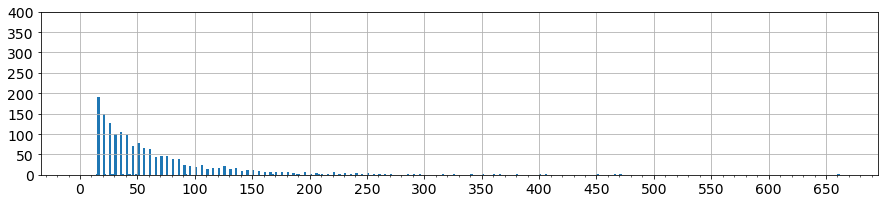

In [2]:
print(str(groompath))
study_name = input('input a single study name: ("921112_L" or "all" )')
if study_name=='all':
    newcsv_lst = sorted(groompath.glob('9*.csv'))
else:
    newcsv_lst = sorted(groompath.glob('{}*.csv'.format(study_name)))
print('find csv ', len(newcsv_lst))
len_lst = []
name_lst = []

len_dict = collections.defaultdict(int)
for newcsv in newcsv_lst:
    fdate = int(newcsv.name.split('_')[0])
    skip = True
    for exp_date in exp_lst:
        if fdate in range(exp_date, exp_date+3):
            skip = False
            break            
    if skip:
#         print('    skip this study {}, not in 3 days of {}'.format(fdate, exp_lst))
        continue
        
    lst = newcsv.stem.split('_')
    start = int(lst[1][1:])
    end = int(lst[2])
    clip_len = end-start+1
    len_lst.append(clip_len+25)
    name_lst.append(newcsv.stem)
    len_dict[clip_len] +=1

print('max len {}, fname {}'.format(max(len_lst), name_lst[np.argmax(len_lst)]))
print('min len {}, fname {}'.format(min(len_lst), name_lst[np.argmin(len_lst)]))
print('total count ', len(len_lst), min(len_lst), max(len_lst))    

# fig, ax = plt.subplots(1, 1, figsize=(15, 3))
# hist,_,_ = ax.hist(len_lst, bins=300, density =False, fc='#2222FF', alpha=0.8)   
# ax.xaxis.set_major_locator(MultipleLocator(50))
# ax.xaxis.set_minor_locator(MultipleLocator(10))
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14) 
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)      

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
max_len = max(list(len_dict.keys()))
y_lst = [0] * (max_len+1)
for k, v in len_dict.items():
    y_lst[k] = v
    
b_lst = [(k,v) for k, v in len_dict.items()]    
print(sorted(b_lst))

ax.bar(range(max_len+1), y_lst, align='center', width = 2);
ax.set_xticks(range(max_len+1), list(len_dict.keys()));
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.set_ylim(0, 400)
ax.grid(True)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)      

# add clip_len to csv filename 

In [5]:
rat_lst = [ '930323', '930324', '930325', '930330']
# ddir = [x for x in dpath.iterdir() if x.is_dir() and x.name.split('-')[0] in rat_lst]
# for all rats
ddir = [x for x in dpath.iterdir() if x.is_dir() and x.name[0]=='9']

ddir = sorted(ddir)
print(str(dpath)) #outpath))
total_count = 0

len_lst = []
for dd in ddir:  

    fdate = int(dd.name.split('-')[0])
    print('{:20s} {}'.format(dd.name, fdate))    
        
    ffilter = '{}_*.mp4'.format(fdate)
    newcsv_lst = sorted(dd.glob(ffilter))
    count = 0
     
    for newcsv in newcsv_lst:
        lst = newcsv.stem.split('_')
        if len(lst)!=3:
            continue
        
        start = int(lst[1][1:])
        end = int(lst[2])
        clip_len = end-start+1
        len_lst.append(clip_len)
        
        target = '{}/{}_{}.mp4'.format(dd, newcsv.stem, clip_len)
        newcsv.rename(target)
        count +=1
        
    print('find {} mp4, rename {} '.format(len(newcsv_lst), count))

d:\rat_data
921111-base-1d       921111
find 299 mp4, rename 299 
921112-base-2d       921112
find 305 mp4, rename 305 
921113-B-car-3-1d    921113
find 263 mp4, rename 263 
921114-B-car-3-2d    921114
find 309 mp4, rename 309 
921115-B-car-3-3d    921115
find 248 mp4, rename 248 
921116-B-car-3-4d    921116
find 303 mp4, rename 303 
921119-B-car-3-7d    921119
find 212 mp4, rename 212 
921120-B-car-3-8d    921120
find 302 mp4, rename 302 
921121-B-car-3-9d    921121
find 264 mp4, rename 264 
921122-B-car-3-10d   921122
find 275 mp4, rename 275 
921123-B-car-3-11d   921123
find 253 mp4, rename 253 
921128-B-car-3-16d   921128
find 187 mp4, rename 187 
921129-B-car-3-17d   921129
find 244 mp4, rename 244 
921130-B-car-3-18d   921130
find 210 mp4, rename 210 
921201-B-car-3-19d   921201
find 250 mp4, rename 250 
921202-B-car-3-20d   921202
find 256 mp4, rename 256 
921203-B-car-3-21d   921203
find 235 mp4, rename 235 
921204-B-car-3-22d   921204
find 230 mp4, rename 230 
921216-base-1d  

# add clip_len to csv filename (single folder)

In [14]:

targetpath = newgroom_oldpath  #groompath)) #outpath))

print(str(targetpath)) 
total_count = 0

len_lst = []
newcsv_lst = sorted(targetpath.glob('9*.csv'))
count = 0
     
for newcsv in newcsv_lst:
    lst = newcsv.stem.split('_')
    if len(lst)!=3:
        continue

    start = int(lst[1][1:])
    end = int(lst[2])
    clip_len = end-start+1
    len_lst.append(clip_len)

    target = '{}/{}_{}.csv'.format(targetpath, newcsv.stem, clip_len)
    newcsv.rename(target)
    count +=1
    
print('find {} csv, rename {} '.format(len(newcsv_lst), count))

e:\rat_data\new_grooming_old
find 528 csv, rename 528 


In [6]:
src_path = pathlib.Path('D:\\Dropbox\\直立(rearing)')
# dest_path = pathlib.Path('E:\\rat_data\\short_clip\\921111-base-1d')
src_files = sorted(src_path.glob('*.csv'))
# dest_files = sorted(dest_path.glob('*.csv'))
for newcsv in src_files:
    lst = newcsv.stem.split('_')
    if len(lst)!=3:
        continue
    start = int(lst[1][1:])
    end = int(lst[2])
    clip_len = end-start+1
    len_lst.append(clip_len)

    target = '{}/{}_{}.csv'.format(src_path, newcsv.stem, clip_len)
    newcsv.rename(target)

# change video clip name to the format of csv

In [2]:
import os
ddir = [x for x in dpath.iterdir() if x.is_dir() and x.name[0] =='9']
ddir = sorted(ddir)
pbar = tqdm(total=len(ddir))

for dd in ddir:  
    rat = dd.name[:6]
    print(dd, rat, end=' ')
    mp4_lst = sorted(dd.glob('{}*.mp4'.format(rat)))
    csv_lst = sorted(dd.glob('{}*.csv'.format(rat)))
    csvname_dict = {f.stem[:13]:f.stem for f in csv_lst}
    
    print(len(mp4_lst), len(csv_lst))
    if len(mp4_lst)!= len(csv_lst):
        print('file len inconsist')
        
    for ff in mp4_lst:
        mp4key = ff.stem[:13]
        csv = csvname_dict[mp4key]
        new_mp4name = ff.parent.joinpath(csv+'.mp4')
        os.rename(ff, new_mp4name)        
#         print(ff, new_mp4name) 
#     break    
    pbar.update(1)

  0%|          | 0/46 [00:00<?, ?it/s]

d:\rat_data\921111-base-1d 921111 299 299
d:\rat_data\921112-base-2d 921112 305 305
d:\rat_data\921113-B-car-3-1d 921113 263 263
d:\rat_data\921114-B-car-3-2d 921114 309 309
d:\rat_data\921115-B-car-3-3d 921115 248 248
d:\rat_data\921116-B-car-3-4d 921116 303 303
d:\rat_data\921119-B-car-3-7d 921119 212 212
d:\rat_data\921120-B-car-3-8d 921120 302 302
d:\rat_data\921121-B-car-3-9d 921121 264 264
d:\rat_data\921122-B-car-3-10d 921122 275 275
d:\rat_data\921123-B-car-3-11d 921123 253 253
d:\rat_data\921128-B-car-3-16d 921128 187 187
d:\rat_data\921129-B-car-3-17d 921129 244 244
d:\rat_data\921130-B-car-3-18d 921130 210 210
d:\rat_data\921201-B-car-3-19d 921201 250 250
d:\rat_data\921202-B-car-3-20d 921202 256 256
d:\rat_data\921203-B-car-3-21d 921203 235 235
d:\rat_data\921204-B-car-3-22d 921204 230 230
d:\rat_data\921216-base-1d 921216 164 164
d:\rat_data\921217-base-2d 921217 160 160
d:\rat_data\921218-B-car-1-1d 921218 212 212
d:\rat_data\930203-base-1d 930203 116 116
d:\rat_data\9302

# change tsn_data/rat_no/frame name to the format of csv
## use grooming_lst.txt and nongrooming_lst.txt to rename folder name

In [2]:
import os
  
def get_fnlst(fn):
    lst = []
    with open(fn) as groom_f:
        data = groom_f.readlines()
        for line in data:
            fn = pathlib.Path(line)
            lst.append(fn.stem)
            
    return lst
            
rat_lst = [ '930323',  '930330']

tpath = pathlib.Path('e:/tsn_data')
tdir = [x for x in tpath.iterdir() if x.is_dir() and x.name[0] =='9' and x.name in rat_lst]
tdir = sorted(tdir)
print(tdir)

for tt in tdir:  
    rat = tt.name
    print(tt, rat)
    groom_fn = tt.joinpath('grooming_lst.txt')
    nongroom_fn = tt.joinpath('nongrooming_lst.txt')
    groom_lst = get_fnlst(groom_fn)
    nongroom_lst = get_fnlst(nongroom_fn)
    groom_lst.extend(nongroom_lst)
#     print(groom_lst)        
            
    tt1 = tt.joinpath('frames')
    tt1_dir = [x for x in tt1.iterdir() if x.is_dir()]
    tt1_dir = sorted(tt1_dir)
    for clip in tt1_dir:
        
        clipstr = str(clip.stem) 
        cc = clipstr.split('_', 1)[1].rsplit('_',1)[0]
        
        notfound = True
        for fn in groom_lst:
            if cc in fn:
                new_ccname = clip.parent.joinpath(clipstr.split('_', 1)[0]+'_'+fn)
#                 print(clip.stem, new_ccname)
                os.rename(clip, new_ccname)   
                notfound = False
        if notfound:
            print('notfound ', clip.stem, cc)
        

[WindowsPath('e:/tsn_data/930323'), WindowsPath('e:/tsn_data/930330')]
e:\tsn_data\930323 930323
e:\tsn_data\930330 930330


# 潘老師看過的訂正, 訂正後放到/rat_data/new_grooming_0311/
## 原本標 non-grooming, 潘老師認為是grooming

In [3]:
gpath = pathlib.Path('E:\\rat_data\\viewed so-called non-grooming clips -158\\grooming - 48 out of 158')
gfiles = sorted(gpath.glob('*.mp4'))
glist = [f.stem.rsplit('_', 1)[0] for f in gfiles ]
print(glist)

['930217_L13430', '930217_L47520', '930217_L51970', '930217_L53950', '930217_L59075', '930217_L77185', '930217_R15835', '930217_R16970', '930217_R18075', '930217_R18505', '930217_R20755', '930217_R22925', '930217_R29740', '930217_R30415', '930217_R33760', '930217_R34320', '930217_R34420', '930217_R40420', '930217_R40575', '930217_R41255', '930217_R41910', '930217_R48540', '930217_R52535', '930217_R55410', '930217_R55675', '930217_R59515', '930217_R60585', '930217_R62355', '930217_R63085', '930217_R66090', '930217_R66625', '930217_R66685', '930217_R68630', '930217_R72055', '930217_R73340', '930217_R73425', '930217_R74270', '930217_R74305', '930217_R74965', '930218_L04820', '930218_L06080', '930218_L12495', '930218_L13380', '930218_L13580', '930218_L13985', '930218_L14485', '930218_L20695', '930218_L24130']


In [8]:
rat_lst = [ '930217', '930218']
ddir = [x for x in dpath.iterdir() if x.is_dir() and x.name.split('-')[0] in rat_lst]
ddir = sorted(ddir)
print(str(dpath)) #outpath))
total_count = 0

len_lst = []
for dd in ddir:  

    fdate = int(dd.name.split('-')[0])
    print('{:20s} {}'.format(dd.name, fdate))    
        
    ffilter = '{}_*.csv'.format(fdate)
    newcsv_lst = sorted(dd.glob(ffilter))
    count = 0
    print(len(newcsv_lst) )
    for newcsv in newcsv_lst:
        fname = newcsv.stem.rsplit('_',2)[0]

        if fname in glist:
            newname =  newgroompath.joinpath(newcsv.name)
            print('copy ', fname, ' to ', newname)
            shutil.copyfile(newcsv, newname)
#         if len(lst)!=3:
#             continue
        
#         start = int(lst[1][1:])
#         end = int(lst[2])
#         clip_len = end-start+1
#         len_lst.append(clip_len)
        
#         target = '{}/{}_{}.mp4'.format(dd, newcsv.stem, clip_len)
#         newcsv.rename(target)
#         count +=1
        
    print('find {} mp4, rename {} '.format(len(newcsv_lst), count))

e:\rat_data
930217-base-1d       930217
923
copy  930217_L13430  to  e:\rat_data\new_grooming\930217_L13430_13454_25.csv
copy  930217_L47520  to  e:\rat_data\new_grooming\930217_L47520_47589_70.csv
copy  930217_L51970  to  e:\rat_data\new_grooming\930217_L51970_51979_10.csv
copy  930217_L53950  to  e:\rat_data\new_grooming\930217_L53950_53999_50.csv
copy  930217_L59075  to  e:\rat_data\new_grooming\930217_L59075_59089_15.csv
copy  930217_L77185  to  e:\rat_data\new_grooming\930217_L77185_77239_55.csv
copy  930217_R15835  to  e:\rat_data\new_grooming\930217_R15835_15854_20.csv
copy  930217_R16970  to  e:\rat_data\new_grooming\930217_R16970_17009_40.csv
copy  930217_R18075  to  e:\rat_data\new_grooming\930217_R18075_18094_20.csv
copy  930217_R18505  to  e:\rat_data\new_grooming\930217_R18505_18524_20.csv
copy  930217_R20755  to  e:\rat_data\new_grooming\930217_R20755_20809_55.csv
copy  930217_R22925  to  e:\rat_data\new_grooming\930217_R22925_22969_45.csv
copy  930217_R29740  to  e:\rat_

# 處理 fp_add to grooming
## 要先把new_grooming_0311 copy 到 new_grooming_rev1
## 底下應該是重新整理分類錯誤的epispde, 放到groom_revised_path
## 希望能建構新的dataset, 讓提高分類準確率
## 之後要跑tsn_my/prepare_data.ipynb  更新e:/tsn_data

In [4]:
fp_add_path = dpath.joinpath('fp_add to grooming')

print('groom_revised_path ', groom_revised_path)
print('fp_add_path ', fp_add_path)

fp_files = sorted(fp_add_path.glob('9*.csv'))
groom_files = sorted(groom_revised_path.glob('9*.csv'))
print('groom_files:', len(groom_files))
print('fp_files:', len(fp_files))

for fp in fp_files:
    newname = groom_revised_path.joinpath(fp.name)
    shutil.copyfile(fp, newname)

groom_files = sorted(groom_revised_path.glob('9*.csv'))
print('after adding fp, groom_files:', len(groom_files))

groom_revised_path  e:\rat_data\new_grooming_rev2
fp_add_path  e:\rat_data\fp_add to grooming
groom_files: 4397
fp_files: 120
after adding fp, groom_files: 4517


# 處理 fn_remove from grooming
## 底下應該是重新整理分類錯誤的epispde, 放到groom_revised_path
## 希望能建構新的dataset, 讓提高分類準確率

In [5]:
fn_remove_path = dpath.joinpath('fn_remove from grooming')

print('groom_revised_path ', groom_revised_path)
print('fn_remove_path ', fn_remove_path)

groom_files = sorted(groom_revised_path.glob('9*.csv'))
fn_files = sorted(fn_remove_path.glob('9*.csv'))
print('groom_files:', len(groom_files))
print('fn_files:', len(fn_files))
groom_lst = [ f.stem for f in groom_files] 
fn_lst = [ f.stem for f in fn_files] 
for fn in fn_lst:
    if fn in groom_lst:
        idx = groom_lst.index(fn)
        os.remove(str(groom_files[idx]))
#         print(fn, groom_files[idx])
    else:
        print('cannot find ', fn)

groom_files = sorted(groom_revised_path.glob('9*.csv'))
print('after removing fn, groom_files:', len(groom_files))


groom_revised_path  e:\rat_data\new_grooming_rev2
fn_remove_path  e:\rat_data\fn_remove from grooming
groom_files: 4517
fn_files: 172
cannot find  930217_R34320_34329_10
cannot find  930217_R34420_34429_10
cannot find  930219_R00945_00989_45
cannot find  930219_R28420_28429_10
after removing fn, groom_files: 4349
